In [1]:
# import packages for research
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco
import cvxopt as opt
from cvxopt import blas, solvers

plt.style.use('fivethirtyeight')
np.random.seed(777)
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# importing data to a dataframe and organizing
data = pd.read_csv("데이터.csv", encoding='cp949')
data.drop([0,1,2], inplace=True)
data.rename(columns={'회사명':'Date'}, inplace=True)
data.set_index("Date", inplace=True)
data = data.apply(pd.to_numeric)
data.head()

,나노신소재,대성파인텍,대주전자재료,신성이엔지보통주,아바코,알에스오토메이션,주성엔지니어링,주식회사케이씨씨,코미코,한화솔루션보통주
Date,,,,,,,,,,
2020/05/04,12450,1155,19300,886,6400,7120,5260,159500,24100,13800
2020/05/06,12900,1215,20400,910,6390,7600,5400,157500,25400,14000
2020/05/07,13200,1225,21100,905,6630,7630,5580,157500,26400,14300
2020/05/08,13200,1225,21300,906,6640,7840,5790,157500,26050,14300
2020/05/11,12950,1230,21250,943,6580,7830,5640,153000,27500,14950


In [11]:
ptc_ret = data.pct_change().dropna()
ptc_ret

,나노신소재,대성파인텍,대주전자재료,신성이엔지보통주,아바코,알에스오토메이션,주성엔지니어링,주식회사케이씨씨,코미코,한화솔루션보통주
Date,,,,,,,,,,
2020/05/06,0.036145,0.051948,0.056995,0.027088,-0.001563,0.067416,0.026616,-0.012539,0.053942,0.014493
2020/05/07,0.023256,0.008230,0.034314,-0.005495,0.037559,0.003947,0.033333,0.000000,0.039370,0.021429
2020/05/08,0.000000,0.000000,0.009479,0.001105,0.001508,0.027523,0.037634,0.000000,-0.013258,0.000000
2020/05/11,-0.018939,0.004082,-0.002347,0.040839,-0.009036,-0.001276,-0.025907,-0.028571,0.055662,0.045455
2020/05/12,-0.027027,0.020325,0.007059,-0.032874,-0.034954,-0.029374,-0.028369,-0.032680,0.016364,0.040134
...,...,...,...,...,...,...,...,...,...,...
2022/05/25,0.008018,0.014963,-0.057411,-0.018519,0.016260,-0.011905,0.002439,0.029630,0.024096,0.012618
2022/05/26,-0.004545,0.063882,-0.015504,0.196765,-0.028000,-0.042169,-0.029197,-0.010072,-0.013445,0.099688
2022/05/27,-0.002283,0.016166,-0.005624,0.002252,-0.004115,0.009434,0.002506,0.023256,0.015332,0.011331


In [12]:
ret_matrix = ptc_ret.values.T
ret_matrix

array([[ 0.03614458,  0.02325581,  0.        , ..., -0.00228311,
         0.0617849 , -0.00646552],
       [ 0.05194805,  0.00823045,  0.        , ...,  0.01616628,
         0.        , -0.01818182],
       [ 0.05699482,  0.03431373,  0.00947867, ..., -0.0056243 ,
         0.01696833, -0.00333704],
       ...,
       [-0.01253918,  0.        ,  0.        , ...,  0.02325581,
         0.00852273, -0.01690141],
       [ 0.05394191,  0.03937008, -0.01325758, ...,  0.0153322 ,
         0.02013423, -0.00164474],
       [ 0.01449275,  0.02142857,  0.        , ...,  0.01133144,
         0.03081232,  0.0611413 ]])

In [13]:
# Random weight generator
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

# Random portfolio generator
def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''
 
    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma, w


In [14]:
#Generate 500 random portfolio (500개의 무작위 포트폴리오 생성)
output = []
for i in range(0,500):
  port_mean, port_std, weights = random_portfolio(ret_matrix)
  mean_std_array = np.array([port_mean, port_std])
  weights_array = np.array(weights)
  merged_array = np.concatenate((mean_std_array,weights_array),axis=None)
  merged_list = merged_array.tolist()
  output.append(merged_list)
 
col_list = list(ptc_ret.columns)
col_list = [i + '_W' for i in col_list]
 
df_col = ['Port_ret','Port_std'] + col_list
port_ret_var = pd.DataFrame(output,columns = df_col)  

In [16]:
#Minimum variance portfolio (최소 분산 포트폴리오)
'''
min 1/2w'COVw
s.t. mu'w = rp and 1'w = 1
'''
def minimum_port_weight(returns):
  mean_ret = np.mean(returns,axis=1)
  cov_ret = np.cov(returns)
  n = mean_ret.shape[0]
  one_array = np.ones(n)
 
  #List of target portfolio returns (목표 포트폴리오 수익률 리스트)
  mus = list(np.arange(0,0.003,0.0001))
    
  # Convert to cvxopt matrices (cvxopt matrix로 변환)
  Q = opt.matrix(cov_ret)
  p = opt.matrix(0.0, (n, 1))
    
  # Create constraint matrices (최적화 문제 제약조건 설정)
  A = opt.matrix(np.stack((mean_ret,one_array)))
  weights_list = []
  mean_std_list = []
  for mu in mus:
    b = opt.matrix(np.array([mu,1]))
    weights = solvers.qp(Q, p, A = A, b = b)['x']
    weight_array = np.array(list(weights))
    port_ret = np.matrix(weight_array).dot(np.matrix(mean_ret).T)
    port_std = np.sqrt(np.matrix(weight_array).dot(np.matrix(cov_ret)).dot(np.matrix(weight_array).T))
    
    weights_list.append(list(weights))
    mean_std_list.append([port_ret[0,0],port_std[0,0]])
  
  return weights_list,mean_std_list


In [17]:
weights,mean_stds = minimum_port_weight(ret_matrix)
#To dataframe (데이타 프레임으로 변경)
col_name = ptc_ret.columns + '_Weight'
weights_df = pd.DataFrame(weights,columns=col_name)
mean_stds_df = pd.DataFrame(mean_stds,columns=['Port_ret','Port_std'])

In [18]:
weights_df.head()

,나노신소재_Weight,대성파인텍_Weight,대주전자재료_Weight,신성이엔지보통주_Weight,아바코_Weight,알에스오토메이션_Weight,주성엔지니어링_Weight,주식회사케이씨씨_Weight,코미코_Weight,한화솔루션보통주_Weight
0,-0.569201,0.131049,-0.032958,-0.086892,0.632193,0.249444,-0.429993,0.457757,0.416872,0.231730
1,-0.544510,0.126026,-0.029172,-0.081402,0.612503,0.243111,-0.408989,0.448399,0.407317,0.226716
2,-0.519820,0.121002,-0.025387,-0.075911,0.592814,0.236779,-0.387984,0.439042,0.397762,0.221703
3,-0.495129,0.115978,-0.021601,-0.070421,0.573125,0.230446,-0.366979,0.429684,0.388207,0.216689
4,-0.470438,0.110955,-0.017815,-0.064931,0.553436,0.224113,-0.345974,0.420327,0.378652,0.211676


In [19]:
mean_stds_df.head()

,Port_ret,Port_std
0,1.084202e-19,0.037475
1,1.000000e-04,0.036361
2,2.000000e-04,0.035259
3,3.000000e-04,0.034172
4,4.000000e-04,0.033101


Text(0.5, 1.0, 'Minimum variance frontier for risky assets')

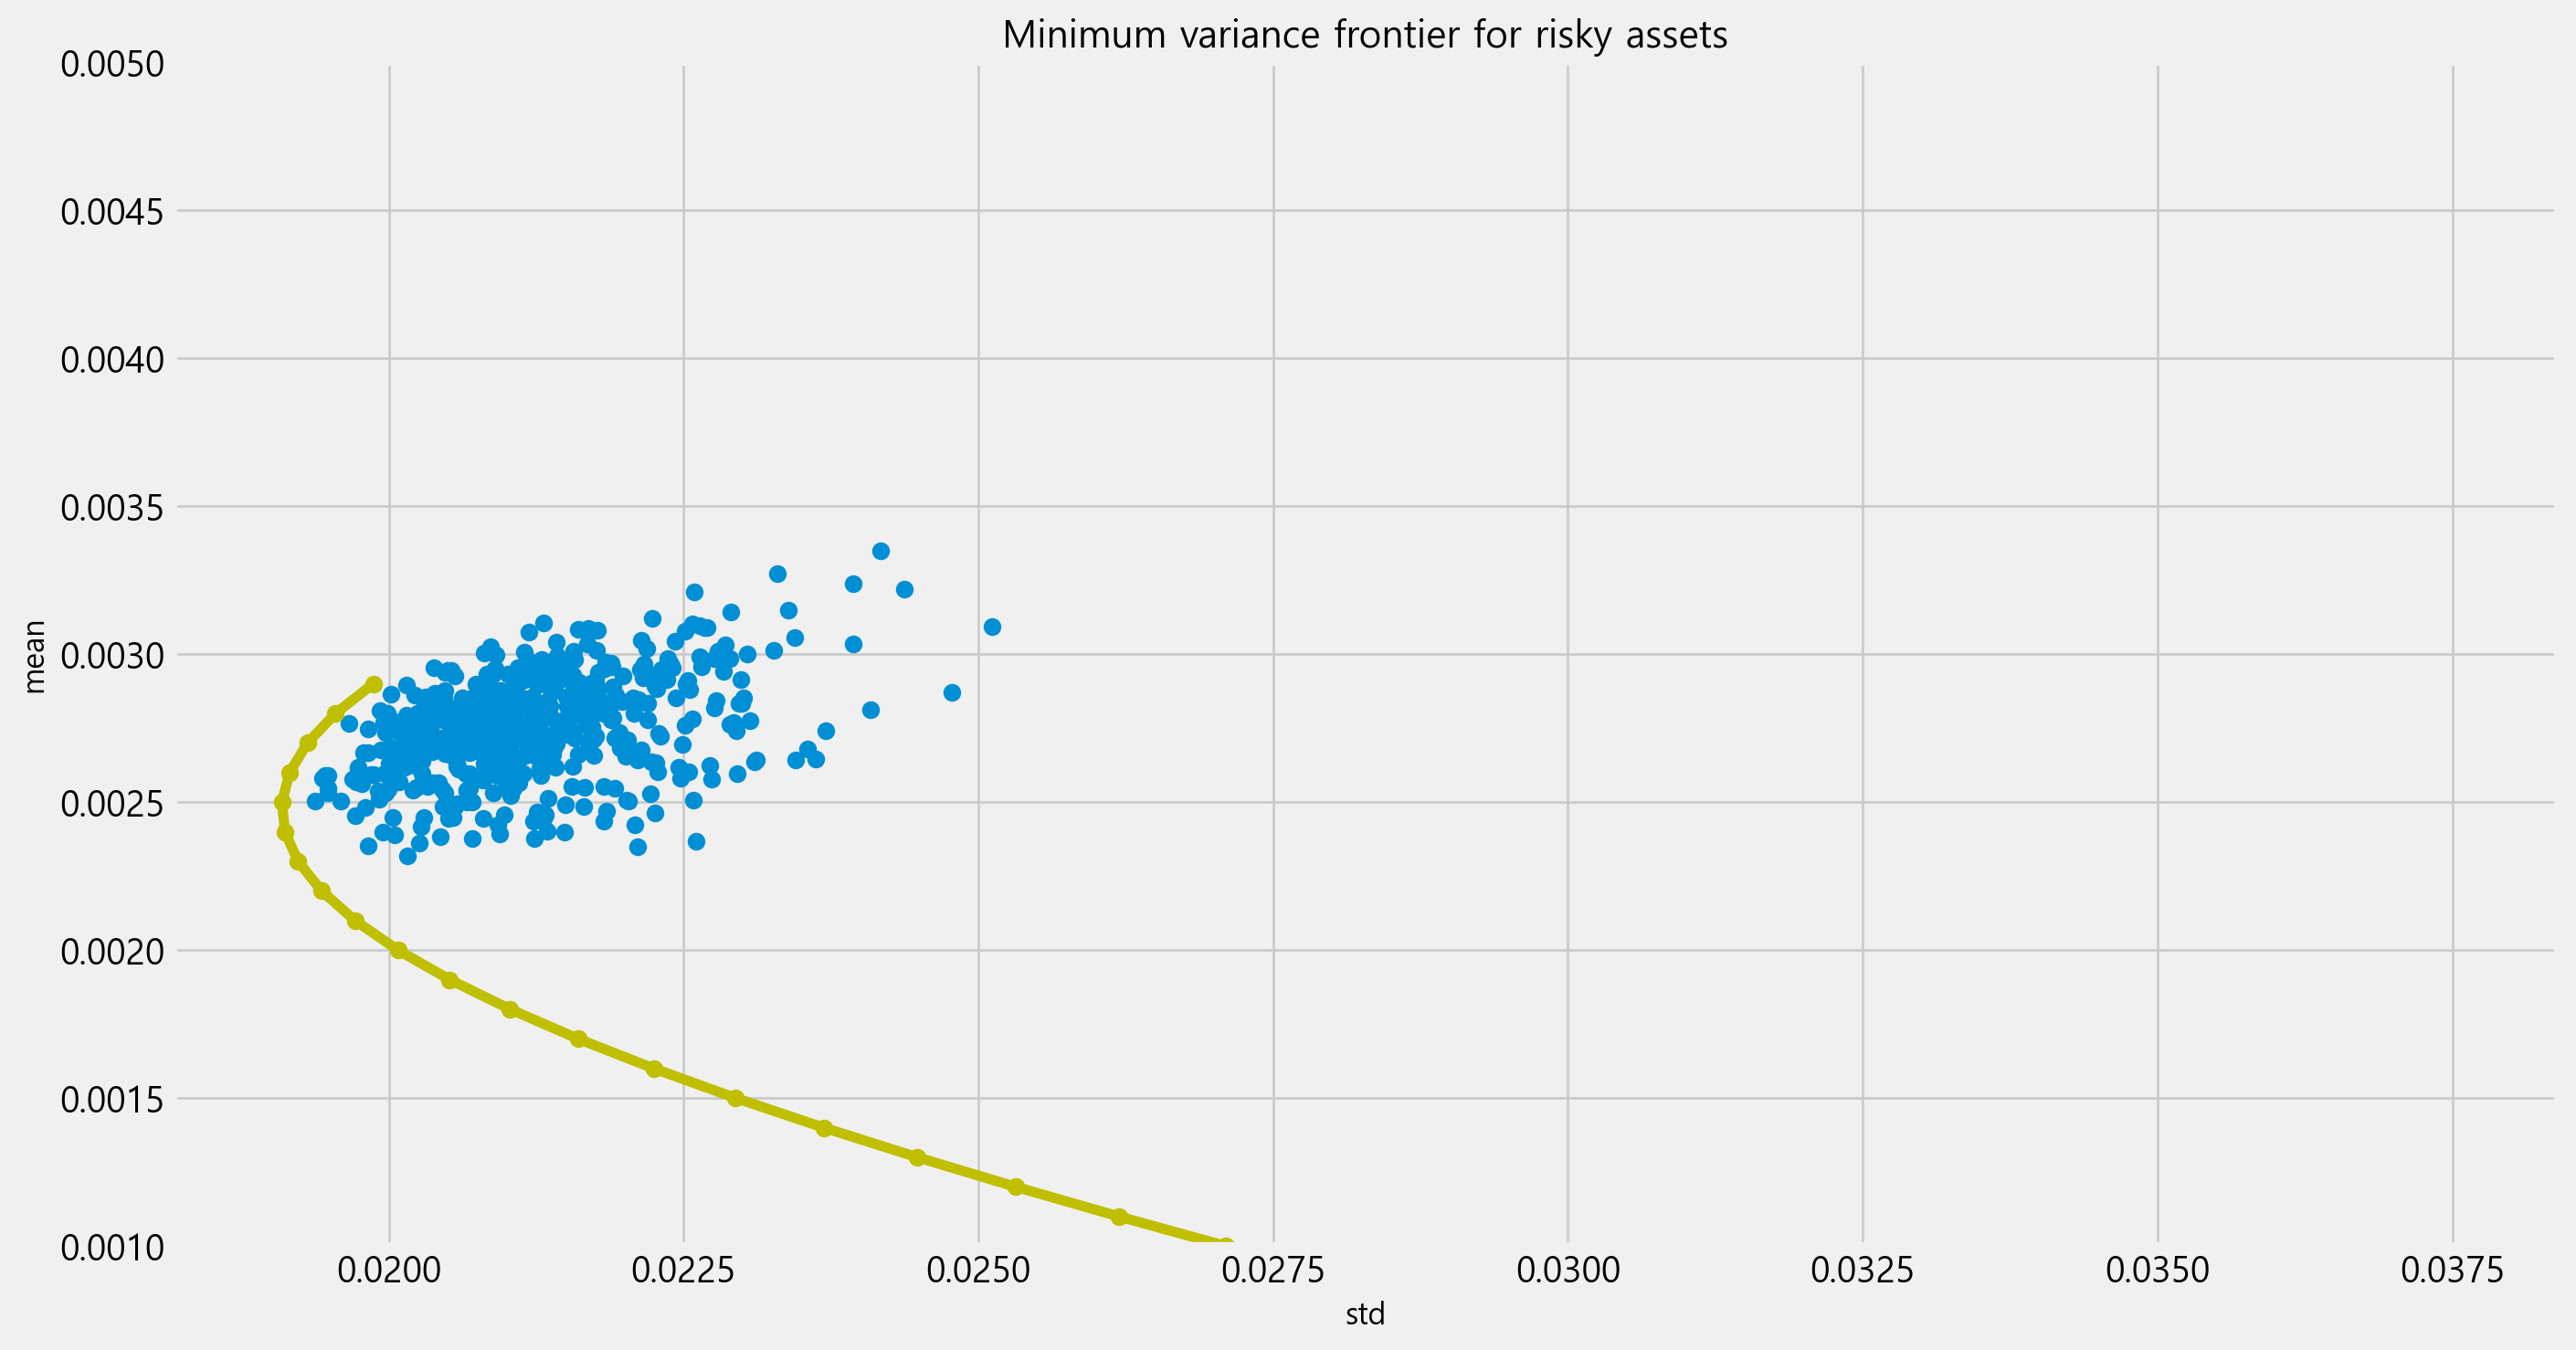

In [27]:
#Plot minimum variance frontier (최소 분산 곡선 그래프)
#Random portfolios (무작위 포트폴리오)
means = port_ret_var['Port_ret'].values
stds = port_ret_var['Port_std'].values
 
#Minimum varaince portfolios (최소분산 포트폴리오)
opt_returns = mean_stds_df['Port_ret']
opt_stds = mean_stds_df['Port_std']
 
fig = plt.figure(figsize=(15,8))
plt.plot(stds, means, 'o')
plt.ylabel('mean',fontsize=12)
plt.xlabel('std',fontsize=12)
plt.plot(opt_stds, opt_returns, 'y-o')
plt.ylim(0.001,.005)
plt.title('Minimum variance frontier for risky assets',fontsize=15)

In [33]:
'''
Tangency portfolio = highest Sharpe ratio with only risky assets
w'1 = 1 needed
 
max (w'mu - rf) / sqrt(w'COVw) -> Sharpe ratio
s.t. w'1 = 1
 
Solution
w_tp = inv(COV)mu / 1'inv(COV)mu 
'''
 
'''
Risk free rate, mean vector, covariance matrix, inverse matrix
(무위험 수익률, 평균 수익률 벡터, 공분산 행렬, 역행렬)
'''
rf = 0.02
mu = np.matrix(np.mean(ret_matrix,axis=1)).T
cov = np.matrix(np.cov(ret_matrix))
cov_inv = np.linalg.inv(cov)
 
top_no = cov_inv.dot(mu)
one_matrix = np.matrix(np.ones(mu.shape[0]))
bottom = one_matrix.dot(cov_inv).dot(mu)
 
tan_weight = top_no/bottom[0,0]
 
#Calculate Shape ratio (Sharpe ratio 계산)
tan_port_ret = tan_weight.T.dot(mu)
tan_port_std = np.sqrt(tan_weight.T.dot(cov).dot(tan_weight))
tan_sharpe = (tan_port_ret[0,0] - rf) / tan_port_std[0,0]

C:\Users\USER\AppData\Local\Temp\ipykernel_4844\2073287825.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y-o" (-> color='y'). The keyword argument will take precedence.
  plt.plot(rf_tan_std, rf_tan_ret, 'y-o',color="red")


Text(0.5, 1.0, 'Mean-Variance Frontier with a risk free asset')

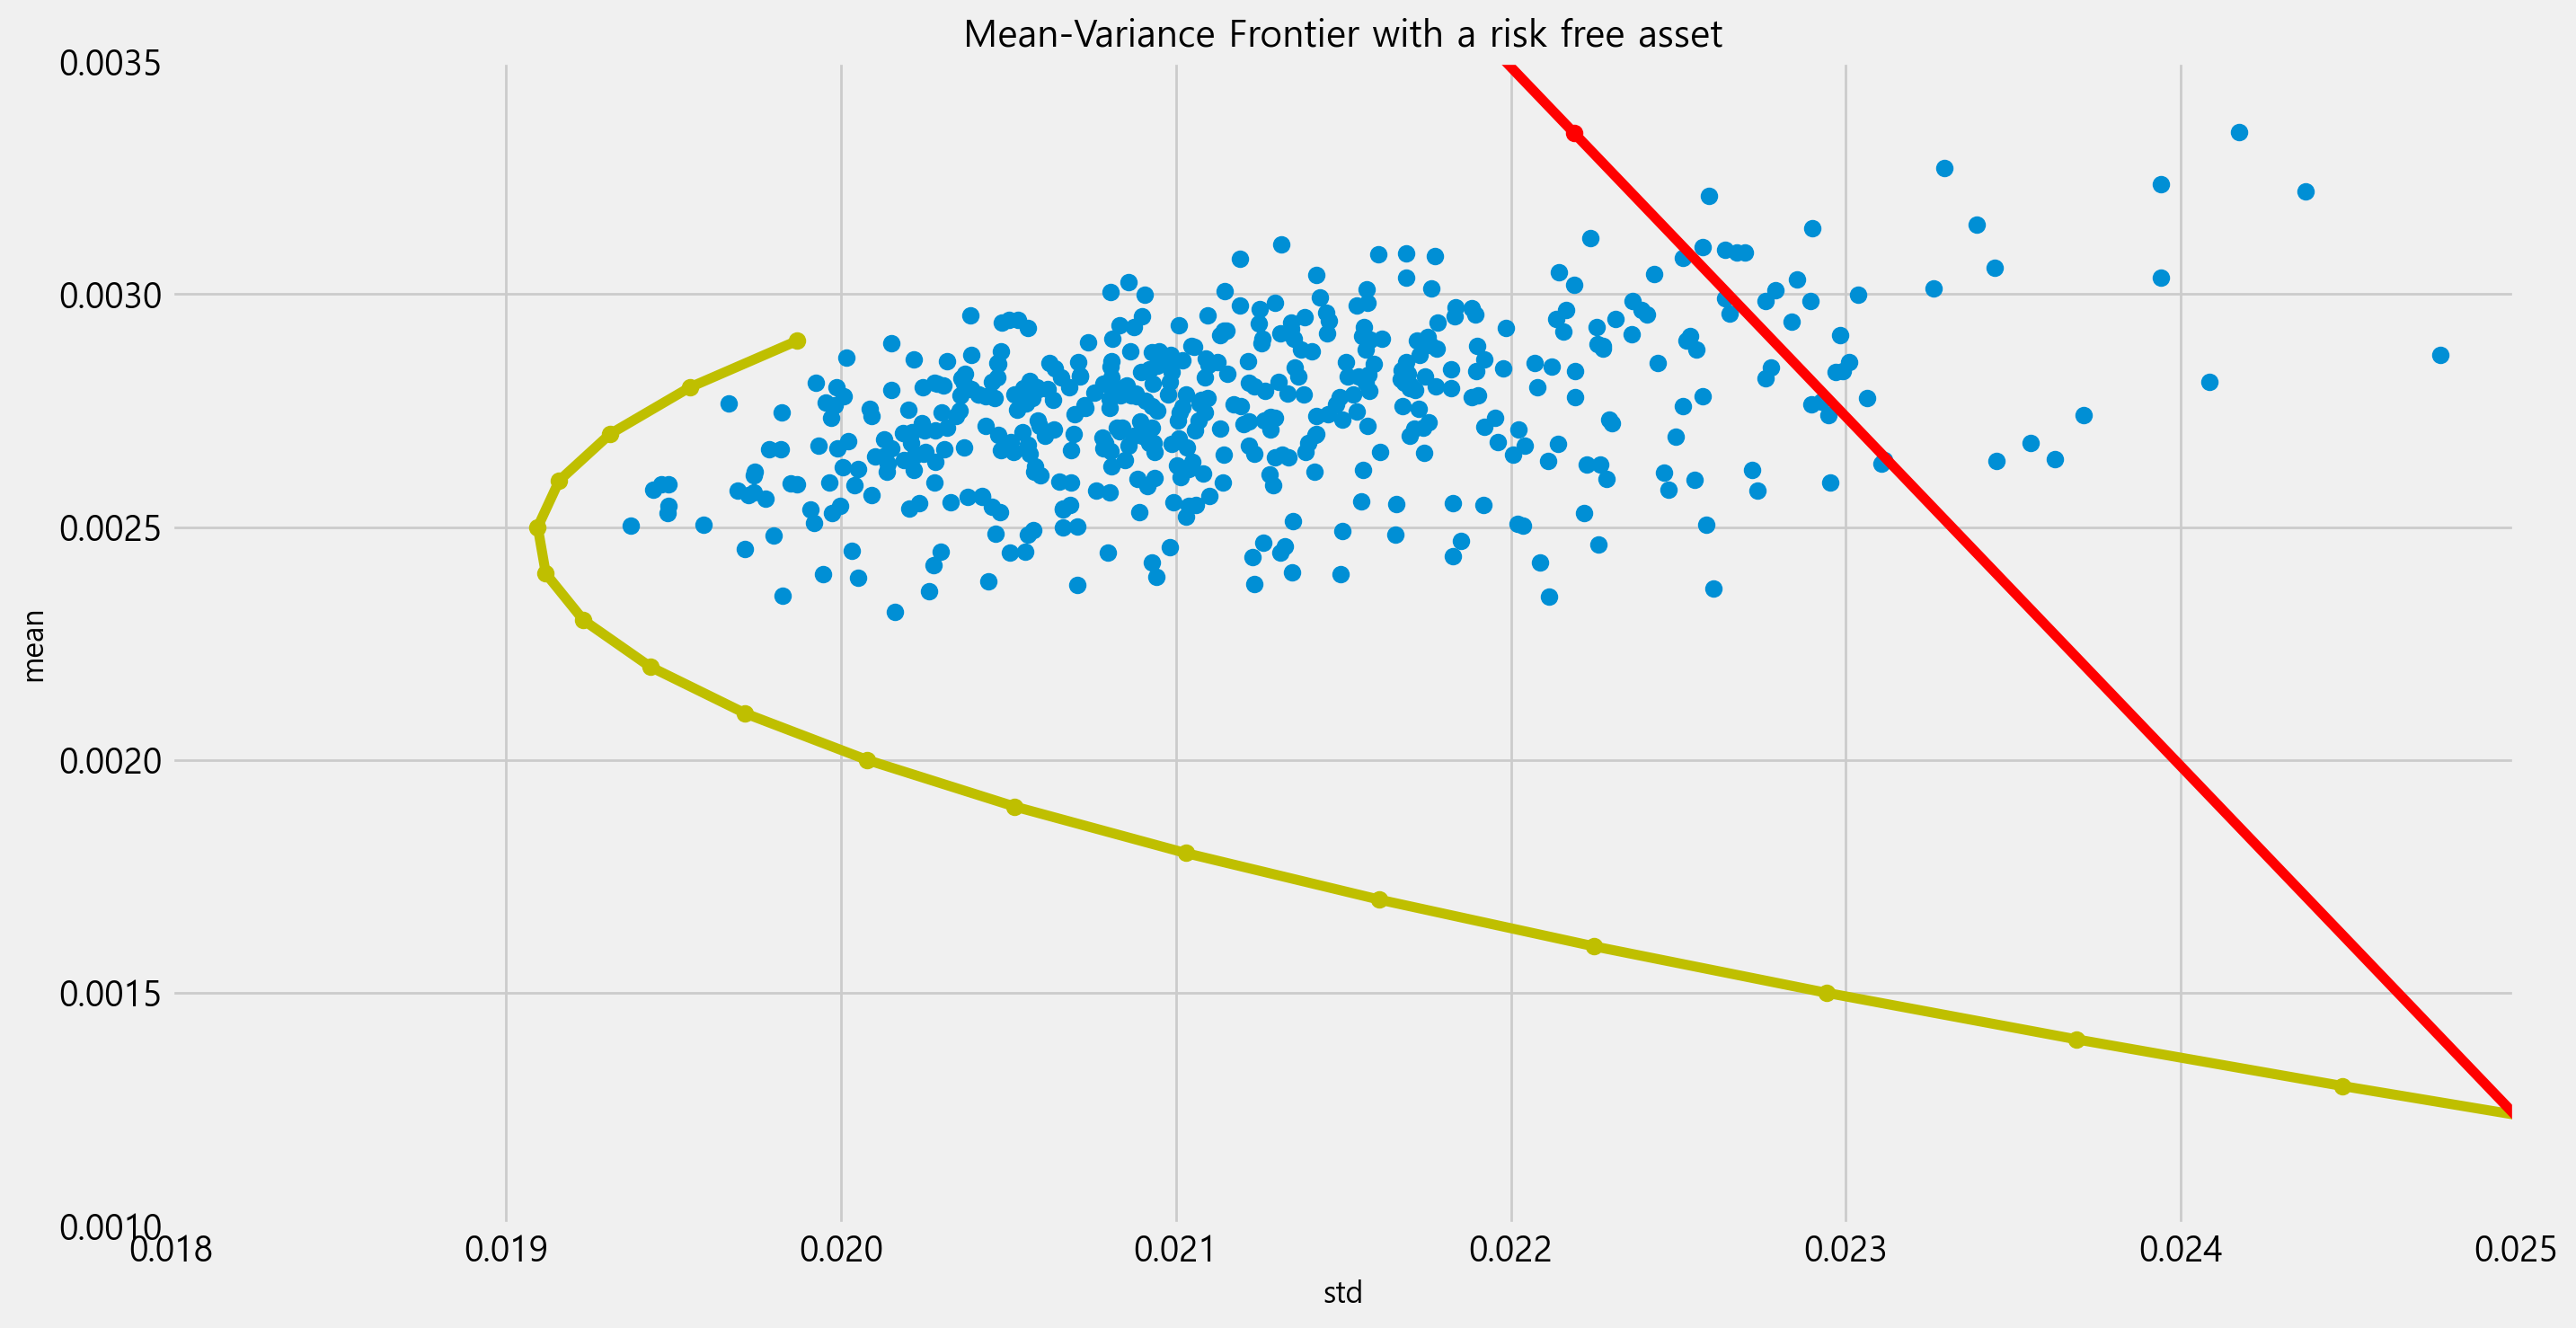

In [34]:
#Generate the third point in the efficient frontier (EFT위의 제3의 점 생성)
tird_eft_std = 0.026
tird_eft_return = tan_sharpe * 0.026 + rf
 
#Random portfolios for Risky assets (위험 자산 랜덤 포트폴리오) 
stds = port_ret_var['Port_std'].values
means = port_ret_var['Port_ret'].values
 
#Minimum varaince portfolios for risky assets (위험 자산 최소 분산 포트폴리오)
opt_returns = mean_stds_df['Port_ret']
opt_stds = mean_stds_df['Port_std']
 
#Efficient frontier with a risk free asset (무위험 자산 존재 시 efficient frontier) 
rf_tan_ret = np.array([rf,tan_port_ret[0,0],tird_eft_return])
rf_tan_std = np.array([0,tan_port_std[0,0],tird_eft_std])
 
fig = plt.figure(figsize=(15,8))
plt.plot(stds, means, 'o')
plt.ylabel('mean',fontsize=12)
plt.xlabel('std',fontsize=12)
plt.plot(opt_stds, opt_returns, 'y-o')
plt.plot(rf_tan_std, rf_tan_ret, 'y-o',color="red")
plt.xlim(0.018,0.025)
plt.ylim(0.0010, 0.0035)
plt.title('Mean-Variance Frontier with a risk free asset',fontsize=15)